In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import random
random.seed(42)

%load_ext autoreload
%autoreload 2

In [4]:
errors = {}
init_data = pd.read_excel("../data/1Artembev_PhC_sport_and_tripms.xls")
main_features = init_data.drop(columns=['day number', 'Speed','Heart rate','Load','Avg PhC 9days', 'Avg PhC 3days',
                                        'Unnamed: 13','Unnamed: 14','Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 
                        'Unnamed: 19', 'Unnamed: 8'], axis=0)
main_features.drop(labels=range(11), inplace=True)
print(main_features.shape)
edited_features = main_features.dropna(axis='rows', how="any")
edited_features = main_features.drop(columns=['Forecast'], axis=0)
print(edited_features.shape)
edited_features.head(10)

(184, 6)
(184, 5)


,Physiological Cost (PhC),TRIMP1,TRIMP2,TRIMP3,TRIMP4
11,0.411155,802.127,138.638,1.23169,0
12,0.395014,1450.13,100.318,1341.57,579.98
13,0.392351,732.626,70.6103,2440.17,1695.58
14,NaN,809.691,13.2364,1778.61,880.455
15,0.408444,769.12,26.4721,1773.54,887.856
16,NaN,1366.48,494.083,1328.01,585.427
17,0.349240,738.895,1.30417,2444.16,1676.64
18,NaN,670.607,10.3701,1779.52,877.502
19,0.396262,722.044,51.7193,1776.15,889.079
20,NaN,NaN,NaN,NaN,NaN


In [5]:
colsDict = {}
means = pd.DataFrame()
for col in edited_features.columns:
    new = f'Mean {col}'
    means[new] = np.zeros(edited_features.shape[0])
    colsDict.update({col:new})

for i in range(1, edited_features.shape[0]):
    for col in colsDict:
        means[colsDict.get(col)].iloc[i] = edited_features[col].iloc[i-1:i+2].mean()
means.head(10)

,Mean Physiological Cost (PhC),Mean TRIMP1,Mean TRIMP2,Mean TRIMP3,Mean TRIMP4
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.399507,994.960748,103.188621,1260.987536,758.520146
2,0.393683,997.482226,61.388053,1853.448052,1052.005165
3,0.400398,770.478993,36.772901,1997.440934,1154.630564
4,0.408444,981.762669,177.930531,1626.721428,784.579500
5,0.378842,958.164133,173.953128,1848.569418,1049.974340
6,0.349240,925.326415,168.585802,1850.559948,1046.523011
7,0.372751,710.515419,21.131176,1999.940352,1147.740144
8,0.396262,696.325461,31.044680,1777.831922,883.290428
9,0.398011,767.086336,33.416780,2104.758831,1301.230254


In [6]:
means.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 5 columns):
Mean Physiological Cost (PhC)    151 non-null float64
Mean TRIMP1                      179 non-null float64
Mean TRIMP2                      179 non-null float64
Mean TRIMP3                      179 non-null float64
Mean TRIMP4                      179 non-null float64
dtypes: float64(5)
memory usage: 7.3 KB


In [7]:
means.dropna(inplace=True)
means.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151 entries, 0 to 183
Data columns (total 5 columns):
Mean Physiological Cost (PhC)    151 non-null float64
Mean TRIMP1                      151 non-null float64
Mean TRIMP2                      151 non-null float64
Mean TRIMP3                      151 non-null float64
Mean TRIMP4                      151 non-null float64
dtypes: float64(5)
memory usage: 7.1 KB


In [12]:
tree = DecisionTreeRegressor(max_depth=1)
X = means.drop(columns=['Mean Physiological Cost (PhC)'])
y = means['Mean Physiological Cost (PhC)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [13]:
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
y_pred

array([0.35855528, 0.35855528, 0.35855528, 0.35855528, 0.35855528,
       0.35855528, 0.35855528, 0.35855528, 0.35855528, 0.35855528,
       0.35855528, 0.35855528, 0.35855528, 0.35855528, 0.35855528,
       0.35855528, 0.35855528, 0.35855528, 0.35855528, 0.35855528,
       0.35855528, 0.35855528, 0.35855528, 0.35855528, 0.35855528,
       0.35855528, 0.35855528, 0.35855528, 0.35855528, 0.35855528,
       0.35855528])

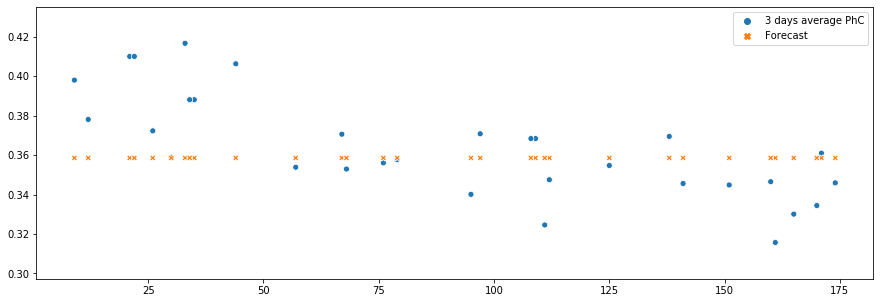

In [14]:
res = pd.DataFrame(columns=['3 days average PhC', 'Forecast'])
res['3 days average PhC'] = y_test
res['Forecast'] = y_pred
figure = plt.figure(figsize=(15,5))
sns.scatterplot(data=res, hue='columns')
# sns.scatterplot(y_test.index, y_test)
# sns.scatterplot(y_test.index, y_pred)

In [15]:
export_graphviz(tree, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = y.name,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0